In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
computer_prices = pd.read_csv("../data/computer_prices.csv")

In [39]:
print(f"Min: ${computer_prices['price'].min()}")
print(f"Max: ${computer_prices['price'].max()}")
print(f"Mean: ${computer_prices['price'].mean():.2f}")

Min: $372.99
Max: $10984.99
Mean: $1928.76


In [36]:
from sklearn.model_selection import train_test_split

In [37]:
low_prices = computer_prices.nsmallest(50, 'price')
high_prices = computer_prices.nlargest(50, 'price')

average_prices = computer_prices[
    ~computer_prices.index.isin(high_prices.index) & 
    ~computer_prices.index.isin(low_prices.index)
]

average_price_bins = pd.qcut(average_prices['price'], q=10, labels=False)

stratified_average_prices, _ = train_test_split(average_prices, test_size=0.9, random_state=42, stratify=average_price_bins)

computer_prices_sample = pd.concat([low_prices, stratified_average_prices, high_prices]).sample(n=10000, random_state=42)

In [38]:
print(f"Min: ${computer_prices_sample['price'].min()}")
print(f"Max: ${computer_prices_sample['price'].max()}")
print(f"Mean: ${computer_prices_sample['price'].mean():.2f}")

Min: $372.99
Max: $10984.99
Mean: $1944.18


In [40]:
computer_prices_sample.to_csv("../data/stratified_computer_prices_sample.csv", index=False)

In [42]:
stratified_computer_prices = pd.read_csv("../data/stratified_computer_prices_sample.csv")

In [43]:
stratified_computer_prices[['resolution_width', 'resolution_height']] = stratified_computer_prices['resolution'].str.split('x', expand=True).astype(int)
stratified_computer_prices['aspect_ratio'] = np.round(stratified_computer_prices['resolution_width'] / stratified_computer_prices['resolution_height'], 2)
stratified_computer_prices.drop('resolution', axis=1, inplace=True)

In [44]:
def extract_cpu_type(cpu_model):
    parts = cpu_model.replace("-", " ").split()

    if parts[0] in ["AMD", "Intel"]:
        parts = parts[:-1]
        
    parts = parts[1:]

    return " ".join(parts).strip()

stratified_computer_prices['cpu_type'] = stratified_computer_prices['cpu_model'].apply(extract_cpu_type)
stratified_computer_prices.drop(['model', 'cpu_model'], axis=1, inplace=True)

In [46]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector

In [53]:
X = stratified_computer_prices.copy()
y = X.pop('price')

price_bins = pd.qcut(y, q=5, labels=False)

preprocessor = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=object))
)

X = preprocessor.fit_transform(X)
y = np.log(y)

X_train, X_temp, y_train, y_temp, bins_train, bins_temp = train_test_split(X, y, price_bins, test_size=0.2, random_state=42, stratify=price_bins)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=bins_temp)

In [54]:
from tensorflow import keras
from tensorflow.keras import Input, layers, callbacks

In [59]:
input_shape = (X_train.shape[1],)

model = keras.Sequential([
    Input(shape=input_shape),
  
    layers.BatchNormalization(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(rate=0.2),
    
    layers.BatchNormalization(),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(rate=0.1),

    layers.Dense(units=1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=200,
    verbose=0,
    callbacks=[early_stopping]
)

Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Minimum Loss: 0.1750
Minimum Validation Loss: 0.0461


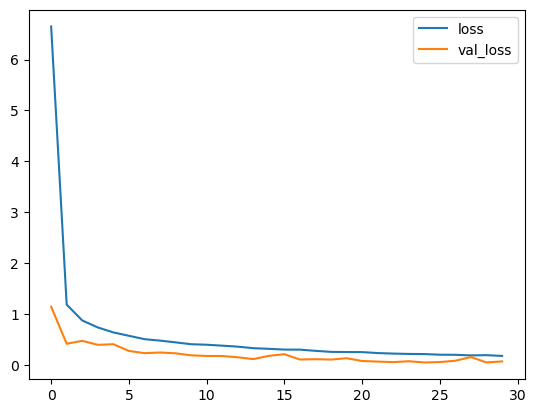

In [60]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

print("Minimum Loss: {:0.4f}".format(history_df['loss'].min()))
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


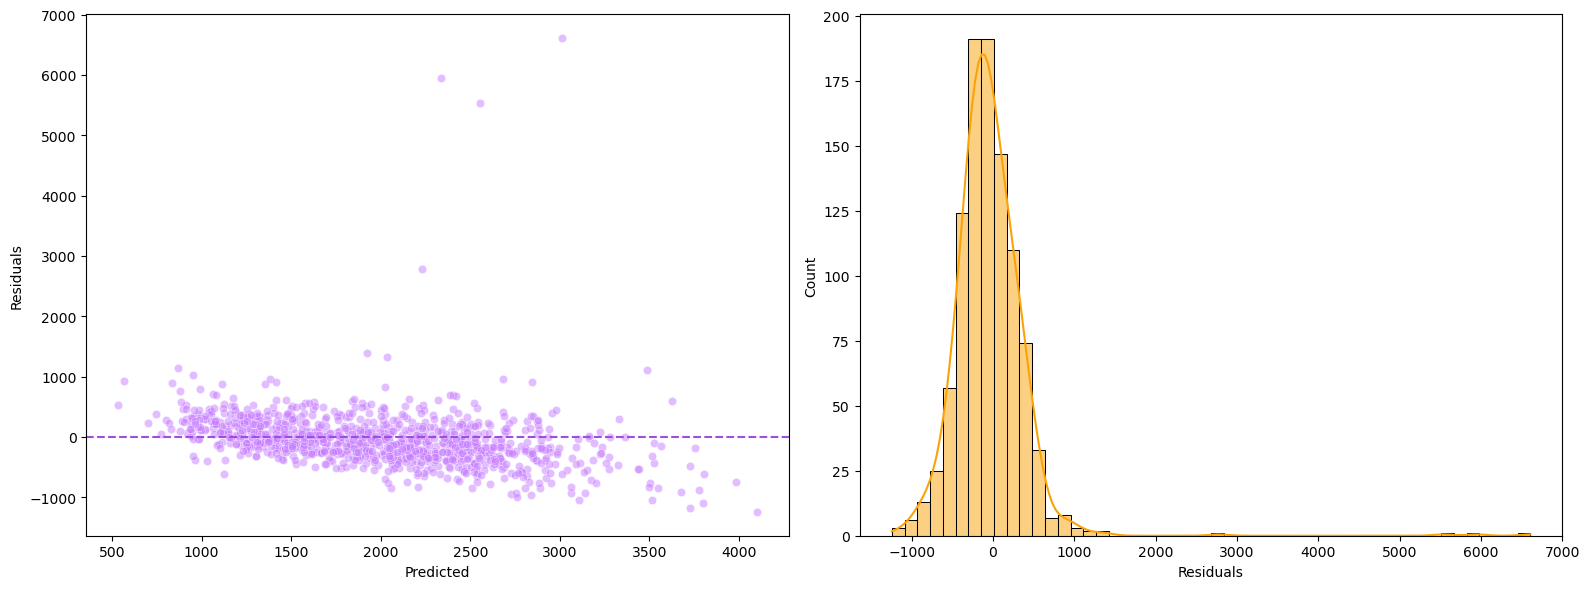

In [87]:
y_pred_log = model.predict(X_test).flatten()

y_pred_price = np.exp(y_pred_log)
y_test_price = np.exp(y_test)

residuals_price = y_test_price - y_pred_price

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_price, y=residuals_price, color='#c77dff', alpha=0.5)

plt.axhline(0, color='#9d4edd', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')


plt.subplot(1, 2, 2)
sns.histplot(residuals_price, bins=50, color='#faa307', kde=True, line_kws={'color': '#ffba08'})
plt.xlabel('Residuals')

plt.tight_layout()
plt.show()

In [88]:
print(f"MAE: ${np.abs(residuals_price).mean():.2f}")
print(f"Median Error: ${np.median(residuals_price):.2f}")
print(f"Std Dev: ${residuals_price.std():.2f}")

MAE: $295.45
Median Error: $-81.09
Std Dev: $489.78


In [90]:
for name, data in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    prices = np.exp(data)
    print(f"{name}:")
    print(f"  Min:  ${prices.min():.0f}")
    print(f"  25%:  ${np.percentile(prices, 25):.0f}")
    print(f"  50%:  ${np.percentile(prices, 50):.0f}")
    print(f"  75%:  ${np.percentile(prices, 75):.0f}")
    print(f"  95%:  ${np.percentile(prices, 95):.0f}")
    print(f"  99%:  ${np.percentile(prices, 99):.0f}")
    print(f"  Max:  ${prices.max():.0f}")

Train:
  Min:  $373
  25%:  $1496
  50%:  $1862
  75%:  $2291
  95%:  $2975
  99%:  $3587
  Max:  $10985
Val:
  Min:  $389
  25%:  $1496
  50%:  $1864
  75%:  $2289
  95%:  $3058
  99%:  $3674
  Max:  $7480
Test:
  Min:  $513
  25%:  $1516
  50%:  $1882
  75%:  $2289
  95%:  $2936
  99%:  $3423
  Max:  $9622
